Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 8 images
Task 1 ✓ — 100 augmented images saved
Task 2 ✓ — 40 patches (32×32) extracted
Task 3 ✓ — ZCA whitening applied

Task 4: Distribution of prewhitened patches


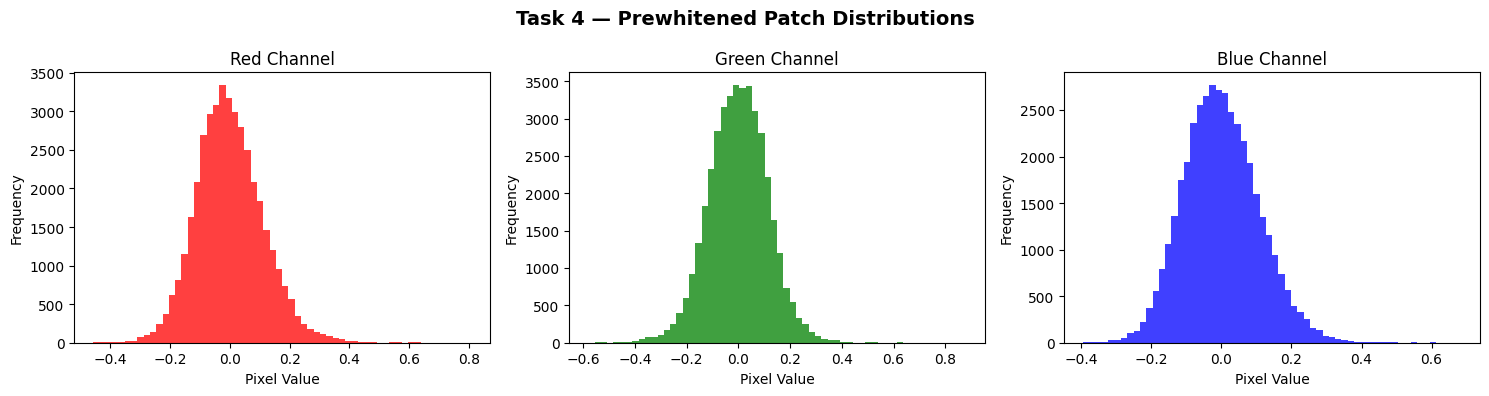

Task 5: Distribution of original patches


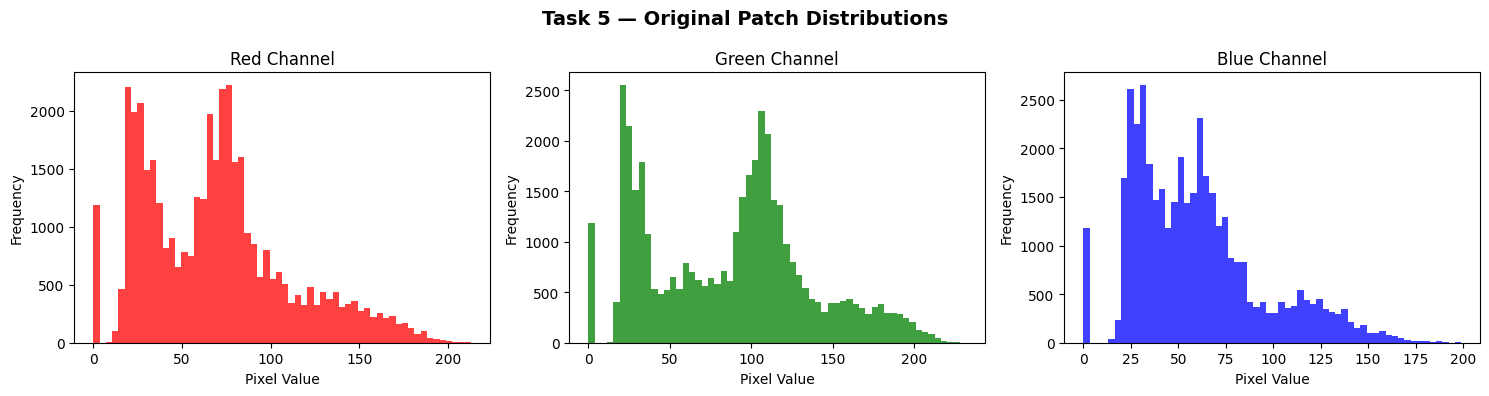


✅ All tasks complete!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os, glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import linalg

IMAGE_DIR  = "/content/drive/MyDrive/leaves"
PATCH_SIZE = 32
NUM_AUG    = 100

os.makedirs("augmented", exist_ok=True)
os.makedirs("patches",   exist_ok=True)
os.makedirs("whitened",  exist_ok=True)


paths  = glob.glob(os.path.join(IMAGE_DIR, "**", "*.jpg"), recursive=True) + \
         glob.glob(os.path.join(IMAGE_DIR, "**", "*.png"), recursive=True)
images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in paths]
print(f"Loaded {len(images)} images")


for i in range(NUM_AUG):
    img = images[i % len(images)].copy()
    h, w = img.shape[:2]

    M = cv2.getRotationMatrix2D((w/2, h/2),
                                angle=np.random.uniform(-30, 30),
                                scale=np.random.uniform(0.8, 1.2))
    M[0, 2] += np.random.uniform(-0.1*w, 0.1*w)
    M[1, 2] += np.random.uniform(-0.1*h, 0.1*h)
    img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    corners = np.float32([[0,0],[w,0],[0,h],[w,h]])
    warped_corners = corners + np.random.uniform(-0.05*w, 0.05*w, corners.shape).astype(np.float32)
    img = cv2.warpPerspective(img, cv2.getPerspectiveTransform(corners, warped_corners),
                              (w, h), borderMode=cv2.BORDER_REFLECT)

    cv2.imwrite(f"augmented/aug_{i:03d}.png", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

print(f"Task 1 ✓ — {NUM_AUG} augmented images saved")


patches = []
for idx, img in enumerate(images):
    h, w = img.shape[:2]
    for p in range(5):
        top  = np.random.randint(0, h - PATCH_SIZE)
        left = np.random.randint(0, w - PATCH_SIZE)
        patch = img[top:top+PATCH_SIZE, left:left+PATCH_SIZE]
        patches.append(patch)
        cv2.imwrite(f"patches/patch_{idx}_{p}.png", cv2.cvtColor(patch, cv2.COLOR_RGB2BGR))

print(f"Task 2 ✓ — {len(patches)} patches ({PATCH_SIZE}×{PATCH_SIZE}) extracted")


X = np.array([p.flatten().astype(np.float64) for p in patches])
X -= X.mean(axis=0)

eigvals, eigvecs = linalg.eigh(np.cov(X, rowvar=False))
W_zca = eigvecs @ np.diag(1.0 / np.sqrt(eigvals + 1e-5)) @ eigvecs.T
X_white = X @ W_zca

for i, row in enumerate(X_white):
    patch = row.reshape(PATCH_SIZE, PATCH_SIZE, 3)
    patch = ((patch - patch.min()) / (patch.max() - patch.min() + 1e-8) * 255).astype(np.uint8)
    cv2.imwrite(f"whitened/white_{i:04d}.png", cv2.cvtColor(patch, cv2.COLOR_RGB2BGR))

print("Task 3 ✓ — ZCA whitening applied")


def plot_channel_distributions(data, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(title, fontsize=14, fontweight="bold")
    for c, (name, color) in enumerate(zip(["Red", "Green", "Blue"], ["red", "green", "blue"])):
        axes[c].hist(data[:, :, :, c].flatten(), bins=60, color=color, alpha=0.75)
        axes[c].set_title(f"{name} Channel")
        axes[c].set_xlabel("Pixel Value")
        axes[c].set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()

whitened_4d = X_white.reshape(len(patches), PATCH_SIZE, PATCH_SIZE, 3)
print("\nTask 4: Distribution of prewhitened patches")
plot_channel_distributions(whitened_4d, "Task 4 — Prewhitened Patch Distributions")

original_4d = np.array(patches)
print("Task 5: Distribution of original patches")
plot_channel_distributions(original_4d, "Task 5 — Original Patch Distributions")

print("\n✅ All tasks complete!")